# Building Chains

In [1]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

In [3]:
messages = [AIMessage(content="Hello, how can I help you today!", name="LLM")]

messages.extend([HumanMessage(content="I am fine, thank you.", name="Human")])
messages.extend([AIMessage(content="Great! I am fine too. How is work going today?", name="LLM")])
messages.extend([HumanMessage(content="Great! all is fine on my end.", name="Human")])

In [4]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: LLM

Hello, how can I help you today!
================================ Human Message =================================
Name: Human

I am fine, thank you.
================================== Ai Message ==================================
Name: LLM

Great! I am fine too. How is work going today?
================================ Human Message =================================
Name: Human

Great! all is fine on my end.


### Load Env

In [10]:
from dotenv import load_dotenv
import os

In [9]:
%reload_ext dotenv
%dotenv

### Chat Models

In [ ]:
# !pip install python-dotenv

# ANTHROPIC_API_KEY=XXXXXX

In [5]:
from langchain_anthropic import ChatAnthropic

In [11]:
model = ChatAnthropic(model="claude-3-5-sonnet-20241022", 
                      api_key=os.environ.get("ANTHROPIC_API_KEY"))

In [12]:
results = model.invoke(messages)

In [14]:
print("Result")
print("===============================")
print(results.content)

Result
Glad to hear everything is going well! Is there anything specific you'd like to discuss or any way I can help you today?


### Tools

In [15]:
def addition(a: int, b: int) -> int:
    """This tool is to be used to add two numbers together"""
    return a + b

In [16]:
llm_with_tool = model.bind_tools([addition])

In [17]:
llm_with_tool_response = llm_with_tool.invoke([HumanMessage(content="What is the sum of 10 and 20", name="Prince")])

In [18]:
print("Result")
print("====================================")
print(llm_with_tool_response)

Result
content=[{'text': "I'll help you add those numbers together using the addition tool.", 'type': 'text'}, {'id': 'toolu_0194qsrSEKjHy5eB3oTdLJPF', 'input': {'a': 10, 'b': 20}, 'name': 'addition', 'type': 'tool_use'}] additional_kwargs={} response_metadata={'id': 'msg_01TWAjfDYqVHvUw8UhjLgaeA', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 401, 'output_tokens': 82}} id='run-6eb9c2a2-9ab8-4377-a872-5ce69fe08673-0' tool_calls=[{'name': 'addition', 'args': {'a': 10, 'b': 20}, 'id': 'toolu_0194qsrSEKjHy5eB3oTdLJPF', 'type': 'tool_call'}] usage_metadata={'input_tokens': 401, 'output_tokens': 82, 'total_tokens': 483, 'input_token_details': {}}


### Using Messages As State

In [21]:
from langchain_core.messages import AnyMessage
from typing import TypedDict, List, Annotated
from langgraph.graph.message import add_messages

In [22]:
class MessageState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

In [23]:
messages = [
    HumanMessage(content="Hello, how are you doing.", name="Prince"),
    AIMessage(content="Hello Prince, am fine thank you.", name="LLM")
]

In [25]:
additional_msg = [HumanMessage(content="I am fine too. How is work on your end.", name="Prince")]


for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Prince

Hello, how are you doing.
================================== Ai Message ==================================
Name: LLM

Hello Prince, am fine thank you.


In [29]:
updated_msg = (add_messages(messages, additional_msg))

In [30]:
for m in updated_msg:
    m.pretty_print()

================================ Human Message =================================
Name: Prince

Hello, how are you doing.
================================== Ai Message ==================================
Name: LLM

Hello Prince, am fine thank you.
================================ Human Message =================================
Name: Prince

I am fine too. How is work on your end.


### Putting It All Together

In [39]:
def tool_calling_llm(state: MessageState) -> MessageState:
    model = ChatAnthropic(model="claude-3-5-sonnet-20241022", 
                      api_key=os.environ.get("ANTHROPIC_API_KEY"))
    
    llm_with_tool = model.bind_tools([addition])
    
    llm_with_tool_response = llm_with_tool.invoke(state["messages"])
    
    return {"messages": [llm_with_tool_response]}

### Building Agent Graph

In [40]:
from langgraph.graph import MessagesState, START, END, StateGraph

In [41]:
builder = StateGraph(MessagesState)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

In [42]:
from IPython.display import display, Image

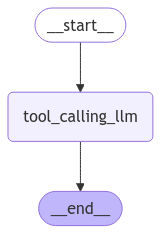

In [43]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Invocation

In [44]:
result = graph.invoke({"messages": HumanMessage(content="What is the sum of 10 and 30", name="Prince")})

print(result)

{'messages': [HumanMessage(content='What is the sum of 10 and 30', additional_kwargs={}, response_metadata={}, name='Prince', id='dc414669-e45b-4c8e-802e-0b2874c59ce4'), AIMessage(content=[{'text': "I'll help you add these numbers together using the addition tool.", 'type': 'text'}, {'id': 'toolu_01E5NEdsx8zBkqJgJV2aEDiG', 'input': {'a': 10, 'b': 30}, 'name': 'addition', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01YS8XWXaiaoyCxqmD84FDKb', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 401, 'output_tokens': 82}}, id='run-084da2fe-0610-4799-92ee-424dc4fa4083-0', tool_calls=[{'name': 'addition', 'args': {'a': 10, 'b': 30}, 'id': 'toolu_01E5NEdsx8zBkqJgJV2aEDiG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 401, 'output_tokens': 82, 'total_tokens': 483, 'input_token_details': {}})]}


In [46]:
result = graph.invoke({"messages": [HumanMessage(content="How are you doing today.", name="Prince")]})

print(result)

{'messages': [HumanMessage(content='How are you doing today.', additional_kwargs={}, response_metadata={}, name='Prince', id='fba138c7-6227-467f-8a41-7eafb6dc55fd'), AIMessage(content='I appreciate you asking, but I notice that your question isn\'t something I can address using the available tools. The only tool I have access to is an "addition" function that adds two numbers together. I can help you with mathematical addition if you\'d like. Would you like to try adding some numbers together?', additional_kwargs={}, response_metadata={'id': 'msg_01BMhwtd4nbPtkNNaAYVu3Ht', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 396, 'output_tokens': 66}}, id='run-164dcfd8-3944-41e7-bbb1-ec4d8765c522-0', usage_metadata={'input_tokens': 396, 'output_tokens': 66, 'total_tokens': 462, 'input_token_details': {}})]}


In [47]:
print(result)

{'messages': [HumanMessage(content='How are you doing today.', additional_kwargs={}, response_metadata={}, name='Prince', id='fba138c7-6227-467f-8a41-7eafb6dc55fd'), AIMessage(content='I appreciate you asking, but I notice that your question isn\'t something I can address using the available tools. The only tool I have access to is an "addition" function that adds two numbers together. I can help you with mathematical addition if you\'d like. Would you like to try adding some numbers together?', additional_kwargs={}, response_metadata={'id': 'msg_01BMhwtd4nbPtkNNaAYVu3Ht', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 396, 'output_tokens': 66}}, id='run-164dcfd8-3944-41e7-bbb1-ec4d8765c522-0', usage_metadata={'input_tokens': 396, 'output_tokens': 66, 'total_tokens': 462, 'input_token_details': {}})]}


In [49]:
graph.aget_state()

TypeError: Pregel.aget_state() missing 1 required positional argument: 'config'